In [3]:
import os
import copy
import logging
import requests
import pprint
import pandas as pd
from pylab import rcParams

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid")

In [4]:

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.getLogger("requests").setLevel(logging.ERROR) # silencing requests logging 

# Logging for this notebook
logger = logging.getLogger()
logger.setLevel(logging.INFO) # set this to whatever you'd like

In [5]:
BASE_URL = 'http://api.open.fec.gov/v1'

API_KEY = open(os.path.expanduser('~/api.txt'),'r').read().strip()

In [6]:
def all_results(endpoint, params):
    _params = copy.deepcopy(params)
    _params.update({'api_key': API_KEY})
    _url = BASE_URL+endpoint
    logging.info('querying endpoint: {}'.format(_url))

    initial_resp = requests.get(_url, params=_params)

    logging.debug('full url eg: {}'.format(initial_resp.url))

    initial_data = initial_resp.json()

    num_pages = initial_data['pagination']['pages']
    num_records = initial_data['pagination']['count']
    logging.info('{p} pages to be retrieved, with {n} records'.format(
            p=num_pages, n=num_records))

    current_page = initial_data['pagination']['page']
    logging.debug('page {} retrieved'.format(current_page))

    for record in initial_data['results']:
        yield record

    while current_page < num_pages:
        current_page += 1
        _params.update({'page': current_page})
        _data = requests.get(_url, params=_params).json()
        logging.debug('page {} retrieved'.format(current_page))
        for record in _data['results']:
            yield record

    logging.info('all pages retrieved')

def count_results(endpoint, params):
    _params = copy.deepcopy(params)
    _params.update({'api_key': API_KEY})
    _url = BASE_URL+endpoint

    _data = requests.get(_url, params=_params).json()

    return _data['pagination']['count']

In [7]:
q_obama = {
    'q': 'obama',
}

pprint.pprint([r for r in all_results('/candidates/search', q_obama)])

[{'active_through': 2010,
  'candidate_id': 'S4IL00180',
  'candidate_status': 'C',
  'cycles': [2002, 2004, 2006, 2008, 2010],
  'district': '00',
  'district_number': 0,
  'election_districts': ['00', '00'],
  'election_years': [2004, 2010],
  'incumbent_challenge': 'I',
  'incumbent_challenge_full': 'Incumbent',
  'load_date': '2009-02-02',
  'name': 'OBAMA, BARACK',
  'office': 'S',
  'office_full': 'Senate',
  'party': 'DEM',
  'party_full': 'Democratic Party',
  'principal_committees': [{'candidate_ids': ['S4IL00180'],
                            'committee_id': 'C00411934',
                            'committee_type': 'S',
                            'committee_type_full': 'Senate',
                            'cycles': [2006, 2010, 2008],
                            'designation': 'P',
                            'designation_full': 'Principal campaign committee',
                            'expire_date': '2015-06-24T00:00:00+00:00',
                            'first_file_da

In [8]:
#Pull list of MN Pols from 2014.

q_mn_2014_candidates = {
    "cycle": 2014,
    "state": 'MN',
    "candidate_status": "C",
    'designation': 'P'
}

count_results('/candidates', q_mn_2014_candidates)

23

In [9]:
mn_candidates_2014 = [c for c in all_results('/candidates', q_mn_2014_candidates)]
mn_2014 = pd.DataFrame(mn_candidates_2014)
mn_2014[['name']]

,name
0,"BENSON, MICHAEL (MIKE) WAYNE"
1,"BYBERG, VIDAR"
2,"DENNEY, JOHN"
3,"ELLISON, KEITH MAURICE"
4,"EMMER, THOMAS EARL JR."
5,"GERSON, DAVID ADAM"
6,"GRAVES, JAMES JOSEPH"
7,"HAGEDORN, JAMES"
8,"KLINE, JOHN PAUL JR"
9,"KRINKIE, PHILIP B"


In [10]:
mn_2014_committees = []

for i, row in mn_2014.iterrows():
    endpoint = '/candidate/{c}/committees'.format(c=row.candidate_id)
    for res in all_results(endpoint, {'cycle':2014,
                                      'designation': 'P',
                                      'committee_type': 'H'}):
        res['candidate_id'] = row.candidate_id
        mn_2014_committees.append(res)



mn_2014_committees_df = pd.DataFrame(mn_2014_committees)
mn_2014_committees_df[['name','committee_id','candidate_id']].head()
mn_2014_committees_df[['name']]

,name
0,MIKE BENSON FOR CONGRESS
1,BYBERG FOR CONGRESS
2,JOHN DENNEY FOR CONGRESS
3,ELLISON FOR CONGRESS
4,EMMER FOR CONGRESS
5,GERSON FOR CONGRESS
6,JIM GRAVES FOR CONGRESS
7,FRIENDS OF HAGEDORN
8,KLINE FOR CONGRESS
9,KRINKIE FOR CONGRESS


In [11]:
mn_2014_totals = []

for i, row in mn_2014_committees_df.iterrows():
    endpoint = '/committee/{c}/totals'.format(c=row.committee_id)
    for res in all_results(endpoint, {'cycle':2014}):
        mn_2014_totals.append(res)

mn_2014_totals_df = pd.DataFrame(mn_2014_totals)
mn_2014_totals_df[['committee_id','contributions','disbursements','receipts',]].head()


,committee_id,contributions,disbursements,receipts
0,C00546945,79556.73,79890.98,79890.98
1,C00474452,127120.75,132389.94,144495.70
2,C00561571,5908.20,6221.85,5908.20
3,C00422410,2079755.23,1984754.12,2090932.14
4,C00545749,2032169.84,2030950.22,2049149.96


In [12]:
mn_2014_comm_totals = pd.merge(mn_2014_committees_df, mn_2014_totals_df, how = 'inner', on = 'committee_id')
mn_2014_comm_totals.head()

,candidate_id,candidate_ids,city,committee_id,committee_type,committee_type_full,custodian_city,custodian_name_1,custodian_name_2,custodian_name_full,...,other_disbursements,other_political_committee_contributions,other_receipts,political_party_committee_contributions,receipts,refunded_individual_contributions,refunded_other_political_committee_contributions,refunded_political_party_committee_contributions,transfers_from_other_authorized_committee,transfers_to_other_authorized_committee
0,H4MN01153,[H4MN01153],ROCHESTER,C00546945,H,House,None,None,None,None,...,0.0,0.00,0.00,0.0,79890.98,4180.0,0.0,0.0,0.0,0.0
1,H0MN07059,[H0MN07059],WILLMAR,C00474452,H,House,None,None,None,None,...,0.0,2000.00,0.00,0.0,144495.70,0.0,0.0,0.0,0.0,0.0
2,H4MN06137,[H4MN06137],FOREST LAKE,C00561571,H,House,None,None,None,None,...,0.0,0.00,0.00,0.0,5908.20,0.0,0.0,0.0,0.0,0.0
3,H6MN05183,[H6MN05183],MINNEAPOLIS,C00422410,H,House,MINNEAPOLIS,CARLA,KJELBERG,"KJELBERG, CARLA",...,447022.0,350094.25,78.65,0.0,2090932.14,3328.0,0.0,0.0,0.0,0.0
4,H4MN06087,[H4MN06087],ANOKA,C00545749,H,House,ANOKA,JENNIFER,NISKA,"NISKA, JENNIFER MARIE",...,1105.0,278900.00,0.00,200.0,2049149.96,12275.0,0.0,0.0,0.0,0.0


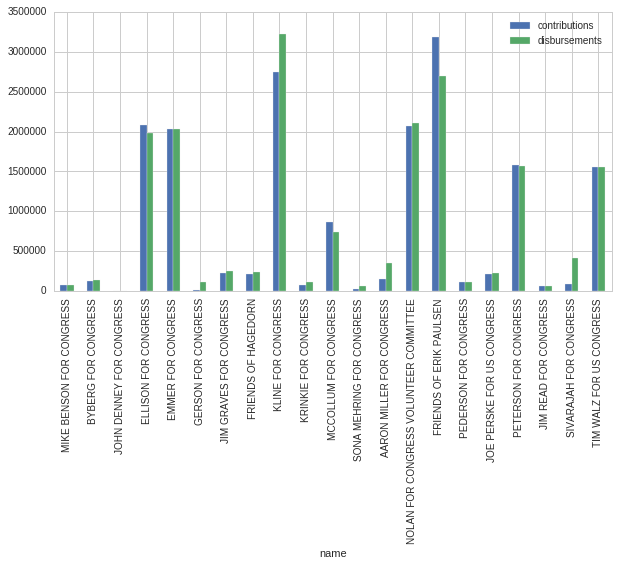

In [13]:
rcParams['figure.figsize'] = 10, 5
mn_2014_comm_totals.set_index('name')[['contributions', 'disbursements']].plot(kind = 'bar')


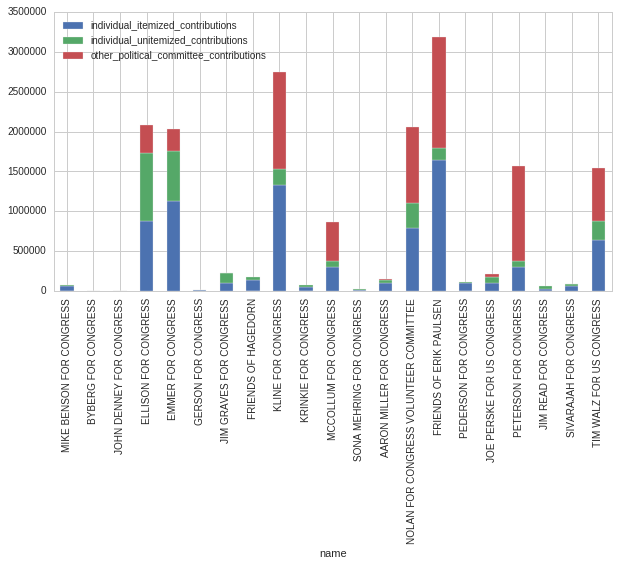

In [14]:
figsize=(10,10)
mn_2014_comm_totals.set_index('name')[['individual_itemized_contributions', 'individual_unitemized_contributions', 
                                       'other_political_committee_contributions',]
                                     ].plot(kind = 'bar', stacked = True)

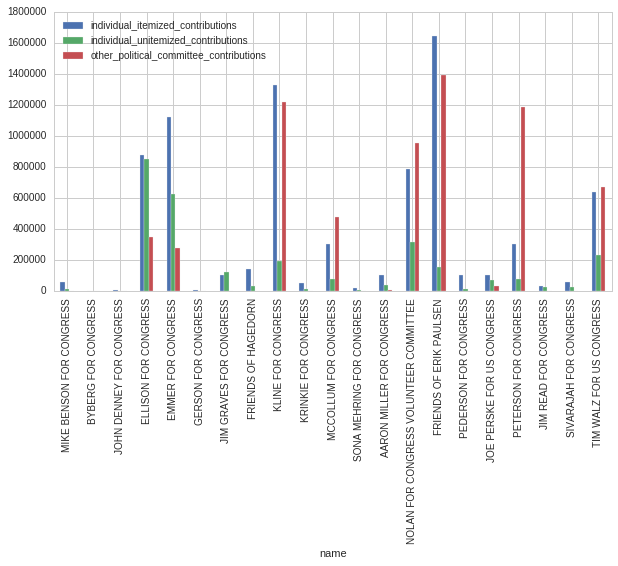

In [15]:
figsize=(10,10)
mn_2014_comm_totals.set_index('name')[['individual_itemized_contributions', 'individual_unitemized_contributions', 
                                       'other_political_committee_contributions',]
                                     ].plot(kind = 'bar')

In [16]:
mn_2014_donors = []

for i, row in mn_2014_committees_df.iterrows():
    endpoint = '/committee/{c}/schedules/schedule_a/by_size'.format(c=row.committee_id)
    for res in all_results(endpoint, {'cycle':2014}):
        mn_2014_donors.append(res)

        
mn_2014_donors_df = pd.DataFrame(mn_2014_donors)
#mn_2014_donors
mn_2014_donors_df.head()

,committee_id,count,cycle,size,total
0,C00546945,NaN,2014,0,12090.00
1,C00546945,18.0,2014,200,4850.00
2,C00546945,21.0,2014,500,10600.00
3,C00546945,18.0,2014,1000,18800.00
4,C00546945,11.0,2014,2000,26333.92


In [17]:
mn_2014_ind_totals = pd.merge(mn_2014_committees_df[['name', 'committee_id']], mn_2014_donors_df, how = 'inner', on = 'committee_id')
mn_2014_ind_totals.head()

,name,committee_id,count,cycle,size,total
0,MIKE BENSON FOR CONGRESS,C00546945,NaN,2014,0,12090.00
1,MIKE BENSON FOR CONGRESS,C00546945,18.0,2014,200,4850.00
2,MIKE BENSON FOR CONGRESS,C00546945,21.0,2014,500,10600.00
3,MIKE BENSON FOR CONGRESS,C00546945,18.0,2014,1000,18800.00
4,MIKE BENSON FOR CONGRESS,C00546945,11.0,2014,2000,26333.92


In [18]:
names = set()

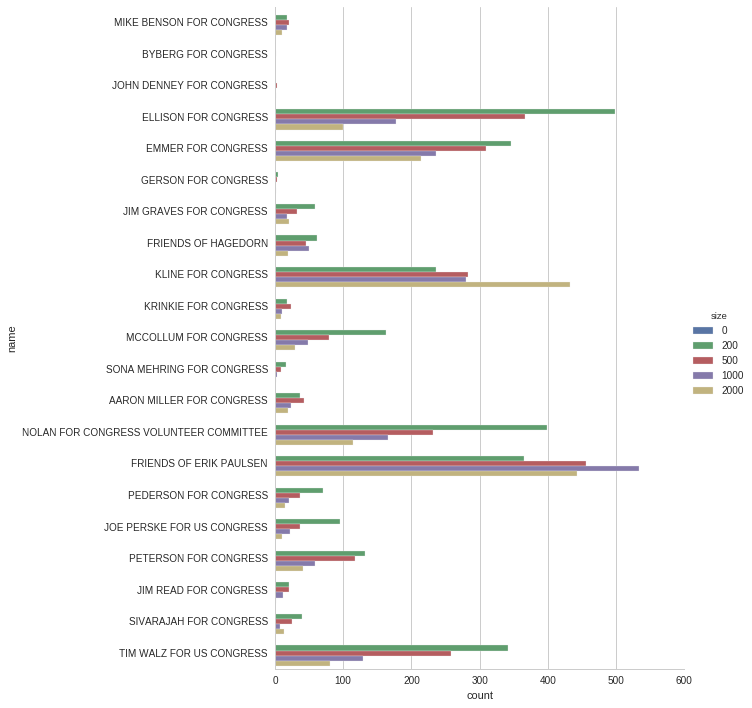

In [19]:

f = sns.factorplot(y='name', x = 'count', hue = 'size', data = mn_2014_ind_totals, kind = 'bar', size = 10)